In [13]:
# Assume the stock price S(t) follows a geometric Brownian motion (GBM) under the real-world measure (drift = risk-free rate)
# Task: price a European Option at time 0
# European Call: right to buy at (stike) price K at maturity T: payoff at expiration is max(S(T)-K,0) --- profitable when K < S(T)
# European Put: right to sell at price K at maturity T: payoff at expiration is max(K-S(T),0) --- profitable when K > S(T)
# Solve S(T). lnS(T) is normally distributed (lognormal distribution with T-dependent drift and variance)
# How much the option is worth today (at t=0): expectation of future payoff under the risk-neutral probability measure, discounted by r
# Result: Call Option Price / Put Option Price. Input: S(0), T, r, d1, d2

In [3]:
#  !pip install yfinance -y

In [4]:
# -----------------------------------------------
# Cell 1: Generate constants from Apple data only
# -----------------------------------------------
import yfinance as yf
import numpy as np

start_date = "2019-01-01"
end_date   = "2024-01-01"

df = yf.download("AAPL", start=start_date, end=end_date)
# Robust extract of closing price
if 'Adj Close' in df.columns:
    prices = df['Adj Close'] # Adjusted Close (price): adjusted for any corporate actions like stock splits or dividends 
else:
    prices = df.iloc[:, 0] # if not: selects the first column of the DataFrame

S0 = float(prices.iloc[-1]) 
# the last row of the prices data: the most recent adjusted closing price
# the initial stock price is the last value in a time series because it represents the current market price. 
# This price is the starting point from which future price movements are simulated or predicted.
log_returns = np.log(prices / prices.shift(1)).dropna() # logarithmic returns: additive
sigma = log_returns.std() * np.sqrt(252) # annualized volatility: approximately 252 trading days in a year

print("Suggested S0    :", round(S0, 4))
print("Suggested sigma :", round(sigma, 4))


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Suggested S0    : 190.9137
Suggested sigma : 0.3225


In [5]:
# -----------------------------------------------
# Cell 2: Option parameters and Black-Scholes inputs
# -----------------------------------------------
import numpy as np
from scipy.stats import norm

# Use values from Cell 1
# S0    : current stock price
# sigma : annualized volatility
# at-the money (zero intrinsic value), in-the-money (positive intrinsic value), out-the-money (negative intrinsic value)
K = S0        # Strike price: the strike price equals the current stock price is considered at-the-money 
T = 5/12      # Time to maturity in years (5 months)
r = 0.02      # Annual continuous risk-free rate
# For simplicity, assume no dividends

print("S0 =", S0)
print("K  =", K)
print("T  =", T)
print("r  =", r)
print("sigma =", sigma)


S0 = 190.91366577148438
K  = 190.91366577148438
T  = 0.4166666666666667
r  = 0.02
sigma = 0.3224960441056325


In [6]:
# -----------------------------------------------
# Cell 3: Black-Scholes option pricing
# -----------------------------------------------

# Compute d1 and d2
d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
# The fundamental principle behind call option pricing is that the price represents the difference between the expected future value of the stock 
# and the expected cost of exercising the option, both adjusted for risk and time.
# Execute call option only when it is ITM (conversely for put option). 
# Compute option prices
# norm.cdf: cumulative distribution function of normal distribution
# Call Price = (Expected Benefit of Owning the Stock) - (Expected Cost of Buying the Stock)
call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
put_price  = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

# Display results
print("d1 =", round(d1, 4))
print("d2 =", round(d2, 4))
print("Phi(d1) =", round(norm.cdf(d1), 4))
print("Phi(d2) =", round(norm.cdf(d2), 4))
print("Call option price  =", round(call_price, 4))
print("Put option price   =", round(put_price, 4))


d1 = 0.1441
d2 = -0.0641
Phi(d1) = 0.5573
Phi(d2) = 0.4745
Call option price  = 16.5655
Put option price   = 14.9811


In [7]:
# -----------------------------------------------
# Cell 4: Option Greeks
# -----------------------------------------------
# a set of risk measures that show how an option's price changes in response to various market factors.
# Delta
delta_call = norm.cdf(d1)
delta_put  = delta_call - 1

# Gamma (same for call and put)
gamma = norm.pdf(d1) / (S0 * sigma * np.sqrt(T))

# Vega (sensitivity to volatility)
vega = S0 * norm.pdf(d1) * np.sqrt(T)

# Theta (time decay)
theta_call = (-S0 * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) 
              - r * K * np.exp(-r * T) * norm.cdf(d2))
theta_put  = (-S0 * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) 
              + r * K * np.exp(-r * T) * norm.cdf(-d2))

# Rho (sensitivity to interest rate)
rho_call = K * T * np.exp(-r * T) * norm.cdf(d2)
rho_put  = -K * T * np.exp(-r * T) * norm.cdf(-d2)

# Display Greeks
print("Delta Call:", round(delta_call, 4), "Delta Put:", round(delta_put, 4))
print("Gamma:", round(gamma, 4))
print("Vega:", round(vega, 4))
print("Theta Call:", round(theta_call, 4), "Theta Put:", round(theta_put, 4))
print("Rho Call:", round(rho_call, 4), "Rho Put:", round(rho_put, 4))


Delta Call: 0.5573 Delta Put: -0.4427
Gamma: 0.0099
Vega: 48.6554
Theta Call: -20.626 Theta Put: -16.8394
Rho Call: 37.4291 Rho Put: -41.4581


In [8]:
# -----------------------------------------------
# Cell 3: Black-Scholes Call and Put Functions
# -----------------------------------------------
from scipy.stats import norm
import numpy as np

def bs_call(S, K, T, r, sigma):
    """Black-Scholes Call Option Price"""
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def bs_put(S, K, T, r, sigma):
    """Black-Scholes Put Option Price"""
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)


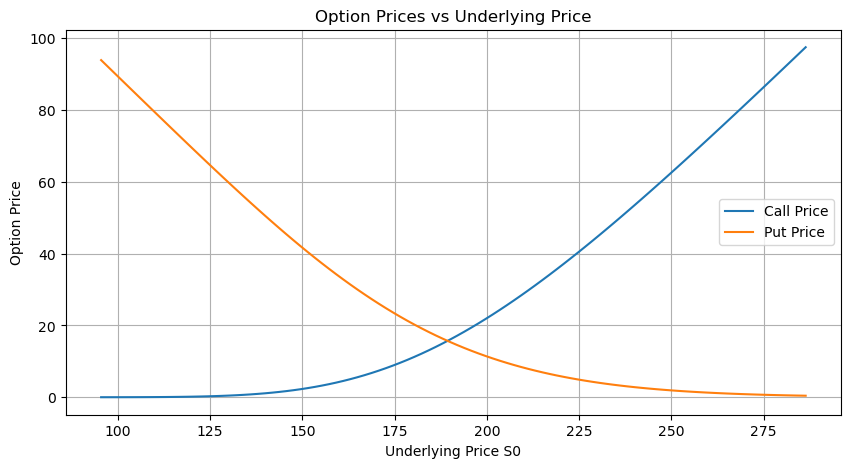

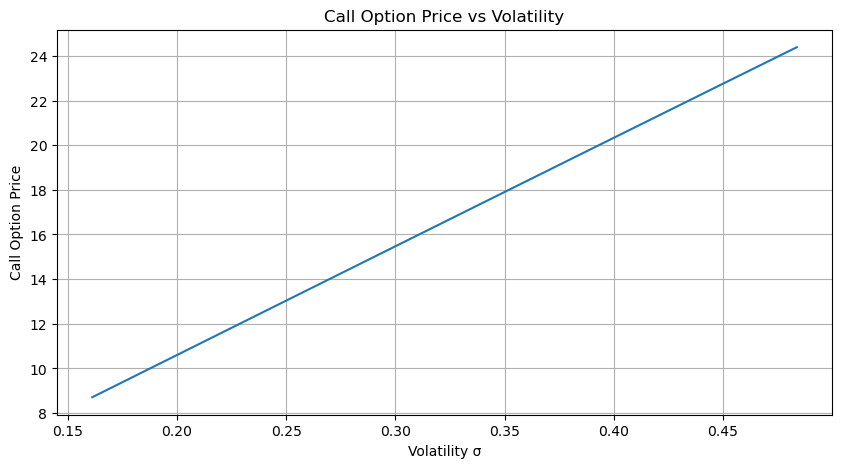

In [9]:
# -----------------------------------------------
# Cell 5: Option Price Visualization
# -----------------------------------------------
import matplotlib.pyplot as plt

# Define range for underlying price and volatility
S_range = np.linspace(0.5*S0, 1.5*S0, 100)
sigma_range = np.linspace(0.5*sigma, 1.5*sigma, 100)

# Call and Put prices as function of S0
call_prices_S = [bs_call(S, K, T, r, sigma) for S in S_range]
put_prices_S  = [bs_put(S, K, T, r, sigma)  for S in S_range]

plt.figure(figsize=(10,5))
plt.plot(S_range, call_prices_S, label="Call Price")
plt.plot(S_range, put_prices_S, label="Put Price")
plt.title("Option Prices vs Underlying Price")
plt.xlabel("Underlying Price S0")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
plt.show()
# The call option price increases as the underlying stock price (S0) increases. 
# This makes sense, as a higher stock price makes the right to buy at a lower strike price more valuable. 

# Call price as function of volatility
call_prices_vol = [bs_call(S0, K, T, r, s) for s in sigma_range]

plt.figure(figsize=(10,5))
plt.plot(sigma_range, call_prices_vol, label="Call Price vs Volatility")
plt.title("Call Option Price vs Volatility")
plt.xlabel("Volatility σ")
plt.ylabel("Call Option Price")
plt.grid(True)
plt.show()
# higher volatility means there's a greater chance for the stock to experience a large price swing

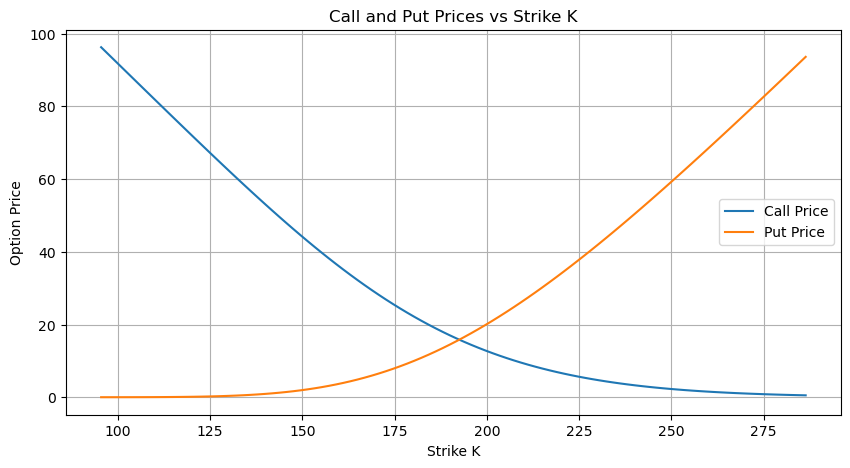

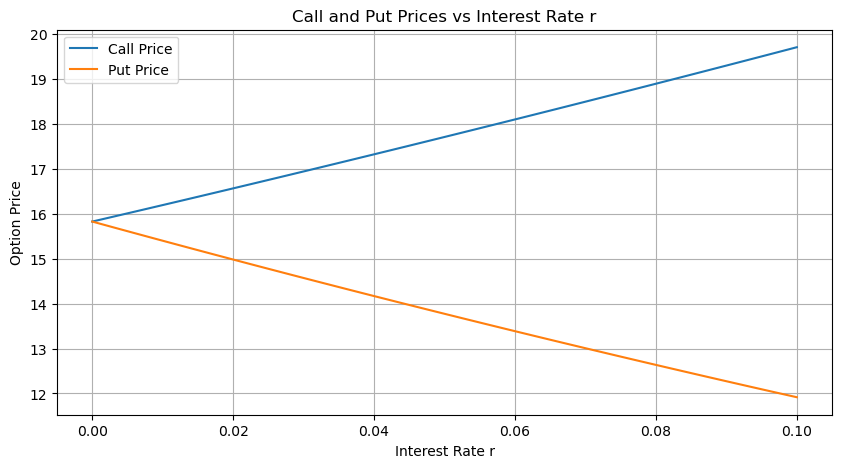

In [10]:
# --- 6. Call and Put Prices vs Strike (K) ---
K_range = np.linspace(0.5*S0, 1.5*S0, 100)  # strike from 50% to 150% of S0
call_prices_K = [bs_call(S0, K, T, r, sigma) for K in K_range]
put_prices_K  = [bs_put(S0, K, T, r, sigma)  for K in K_range]

plt.figure(figsize=(10,5))
plt.plot(K_range, call_prices_K, label="Call Price")
plt.plot(K_range, put_prices_K, label="Put Price")
plt.xlabel("Strike K")
plt.ylabel("Option Price")
plt.title("Call and Put Prices vs Strike K")
plt.legend()
plt.grid(True)
plt.show()
 # a higher strike price means the right to buy the stock is less valuable
# --- 7. Call and Put Prices vs Interest Rate (r) ---
r_range = np.linspace(0, 0.1, 100)  # interest rate from 0% to 10%
call_prices_r = [bs_call(S0, K, T, ri, sigma) for ri in r_range]
put_prices_r  = [bs_put(S0, K, T, ri, sigma) for ri in r_range]

plt.figure(figsize=(10,5))
plt.plot(r_range, call_prices_r, label="Call Price")
plt.plot(r_range, put_prices_r, label="Put Price")
plt.xlabel("Interest Rate r")
plt.ylabel("Option Price")
plt.title("Call and Put Prices vs Interest Rate r")
plt.legend()
plt.grid(True)
plt.show()
# the higher the interest rate, the more valuable this deferral is, 
# as the cash you would have spent on the stock can be invested at a higher return.


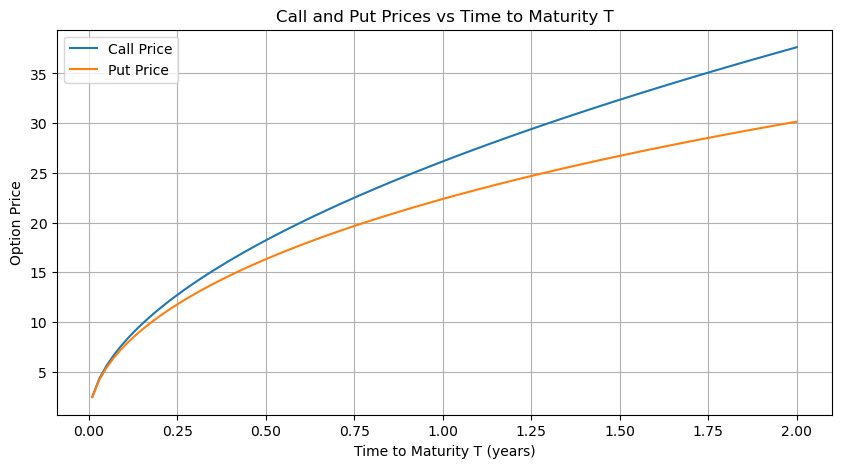

In [11]:
# --- 8. Call and Put Prices vs Time to Maturity (T) ---
T_range = np.linspace(0.01, 2, 100)  # from ~0.01 years (~3.5 days) to 2 years
call_prices_T = [bs_call(S0, K, T_i, r, sigma) for T_i in T_range]
put_prices_T  = [bs_put(S0, K, T_i, r, sigma)  for T_i in T_range]

plt.figure(figsize=(10,5))
plt.plot(T_range, call_prices_T, label="Call Price")
plt.plot(T_range, put_prices_T, label="Put Price")
plt.xlabel("Time to Maturity T (years)")
plt.ylabel("Option Price")
plt.title("Call and Put Prices vs Time to Maturity T")
plt.legend()
plt.grid(True)
plt.show()
# having more time until expiration increases the chance that the underlying stock price will move in a favorable direction
# the rate at which the option's value decreases accelerates (more sensitive) as it approaches its expiration date (T small).

In [12]:
# --- 9. Compute Option Greeks for Call and Put ---
from scipy.stats import norm

# Delta
delta_call = norm.cdf((np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T)))
delta_put  = delta_call - 1

# Gamma (same for call and put)
gamma = norm.pdf((np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))) / (S0*sigma*np.sqrt(T))

# Vega (same for call and put, per 1% change in volatility)
vega = S0 * norm.pdf((np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))) * np.sqrt(T) / 100

# Theta
theta_call = (-S0 * norm.pdf((np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))) * sigma / (2*np.sqrt(T))
              - r*K*np.exp(-r*T)*norm.cdf((np.log(S0/K) + (r - 0.5*sigma**2)*T)/(sigma*np.sqrt(T))))
theta_put = (-S0 * norm.pdf((np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))) * sigma / (2*np.sqrt(T))
             + r*K*np.exp(-r*T)*norm.cdf(-(np.log(S0/K) + (r - 0.5*sigma**2)*T)/(sigma*np.sqrt(T))))

# Display results
print("Delta Call:", round(delta_call, 4), "Delta Put:", round(delta_put, 4))
print("Gamma:", round(gamma, 4))
print("Vega (per 1% vol change):", round(vega, 4))
print("Theta Call:", round(theta_call, 4), "Theta Put:", round(theta_put, 4))


Delta Call: 0.5573 Delta Put: -0.4427
Gamma: 0.0099
Vega (per 1% vol change): 0.4866
Theta Call: -20.626 Theta Put: -16.8394
